# Retroalimentación en sistemas bidimensionales

In [1]:
# Cargamos la paquetería

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from numpy.core.function_base import linspace
from numpy import meshgrid
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from numpy import sqrt, exp, sin, cos

Sabemos que los sistemas bidimensionales de la forma

$$\begin{align*}
\dot{x}=f(x,y),\\
\dot{y}=g(x,y),
\end{align*}$$

pueden ser complicados de analizar tanto analíticamente (i.e. encontrar una solución explícita) como geométricamente (i.e. llevar conclusiones locales sobre los equilibrios a la escala global). En general, ecuaciones como las anteriores definen la manera en que dos poblaciones, variables, aspectos, etc., interactúan entre sí para generar comportamientos propios del fenómeno a estudiar. En este sentido es importante desarrollar intuiciones sobre el tipo de efecto que ejerce una variable sobre la otra, con esperanzas de que esto proporcione información útil sobre el estado del sistema (aunque sea de manera general).

Un concepto importante en la Teoría de control es *retroalimentación*, que se puede definir una situación en que las variables de salida (output) de un sistema reingresan a éste (input) como información de la que depende la futura emisión de más variables de salida, creando así un *bucle de retroalimentación* (como sucede en la traducción y transcripción de genes). La situación contraria a la retroalimentación es la *prealimentación*, que se da cuando una variable de salida de un sistema funciona como variable de entrada de otro sistema, pero este último no envía información de regreso al sistema inicial. El siguiente ejemplo establece las diferencias entre ambos conceptos:

- Un arquero puede ajustar la dirección de la flecha que va a lanzar vigilando la posición de su presa. En este caso, la presa emite una variable de salida, su posición, de la que depende la dirección y fuerza de lanzamiento del arquero.
- Si la presa es consciente de que el arquero intenta cazarla, intentará predecir el punto de caída de la flecha para evitarla. Consecuentemente, el arquero ajustará la flecha a la nueva posición de la presa, cerrando el ciclo entre ambos sistemas.

En un modelo basado en ecuaciones diferenciales como el anterior, la dependencia de una variable con respecto de otra se hace explícita en el campo vectorial que define al sistema: si $y$ aparece explícitamente en la ecuación para $\dot{x}$, y $x$ aparece explícitamente en las ecuaciones para $\dot{y}$, entonces se cierra el bucle y estaremos en presencia de retroalimentación entre ambas variables. Si solo una depende de la otra, pero no en el sentido contrario, entonces hablaremos de prealimentación.

Existen distintos tipos de retroalimentación, i.e. diferentes formas en que una variable puede actuar sobre la otra y viceversa. A continuación veremos algunos ejemplos que ilustren esto.

## Modelo presa-depredador de Lotka-Volterra

Este modelo, que ya hemos mencionado algún par de veces, toma la forma

$$\begin{align*}
\dot{x}&=ax-bxy,\\
\dot{y}&=cxy-dy,
\end{align*}$$

donde $a$, $b$, $c$, $d$ son constantes positivas. En la expresión anterior, $x$ es el tamaño de la población presa y $y$ es el tamaño de la población depredadora. Intuitivamente podemos imaginar el efecto que cada variable tiene sobre la otra, pero para este análisis conviene que nos fijemos concretamente en las reglas de evolución del sistema. En concreto notamos que

- Si la presa incrementa, entonces el depredador incrementa por el término $cxy$ (se hace más grande y está sumando)
- Si el depredador incrementa, entonces la presa decrementa por el témrino $bxy$ (se hace más grande y está restando)
- Si la presa decrementa, entonces el depredador decrementa por el término $cxy$ (se hace más chico y está sumando)
- Si el depredador decrementa, entonces la presa incrementa por el término $bxy$ (se hace más chico y está restando)

Estas observaciones las podemos reducir en una sola cadena de efectos, escrita como
$$x\nearrow y\nearrow x\searrow y\searrow x\nearrow,$$

de donde podemos predecir que los efectos son cíclicos a partir de la quinta flecha. Para determinar el tipo de efecto, i.e. la retroalimentación, que presenta este sistema, debemos fijarnos en el efecto que tiene un incremento (o decremento) de una variable sobre ella misma. Por ejemplo, sabemos que

$$x\nearrow y\nearrow x\searrow,$$

por lo que incrementos de la presa conllevan, eventualmente, a decrementos de la misma. Este comportamiento se observa también en el depredador, y es independiente si se empezó el análisis con un incremento o con un decremento. Como variaciones en cada variable implican más variaciones *en sentido contrario*, podemos decir que el sistema de Lotka-Volterra presenta **retroalimentación negativa**.

Una obsrvación rápida es que empezamos a introducir conceptos matemáticos como variaciones respecto de una o más variables. Esto podría formalizarse en términos de derivadas, lo cuál es adecuado ya que el sistema estaba planteado originalmente como una ecuación diferencial. Si calculamos el producto

$$\dfrac{\partial\dot{y}}{\partial x}\dfrac{\partial\dot{x}}{\partial y}=(cy)(-bx)=-bcxy<0,$$

notaremos que este producto es negativo siempre que $x$ y $y$ sean ambas positivas (lo cuál es sensato en el caso de modelos ecológicos). Concluimos nuevamente que la retroalimentación de este sistema es **negativa**.

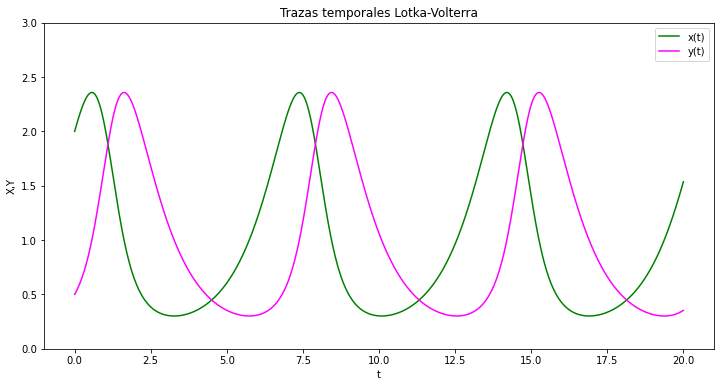

In [5]:
a = 1.0
b = 1.0
c = 1.0
d = 1.0

def LV(x,y):
    u = a*x-b*x*y
    v = c*x*y-d*y
    return [u,v]

def LV_int(u,t):
    x, y = u
    return LV(x,y)

x0 = 2.0   # Presa
y0 = 0.5   # Depredador
u0 = [x0,y0]

t = linspace(0,20,10001)

U = odeint(LV_int,u0,t)
X = U[:,0]
Y = U[:,1]

pt = plt.figure(figsize=(12,6))
pt = plt.plot(t,X,label='x(t)', color = 'green')
pt = plt.plot(t,Y,label='y(t)', color = 'magenta')
pt = plt.title('Trazas temporales Lotka-Volterra')
pt = plt.xlabel('t')
pt = plt.ylabel('X,Y')
pt = plt.ylim(0,3)
pt = plt.legend()

**Observación:** usaremos productos consecutivos como el anterior para evaluar la retroalimentación que experimentan dos variables.

## Ejemplo 2: FitzHugh-Nagumo

Recordamos que la reducción geométrica para el problema de generación de potenciales de acción está dado por

$$\begin{align*}
\dot{V}&=\beta V-\tfrac{V^3}{3}-w+I,\\
\dot{w}&=\dfrac{1}{\tau}(aV-w-b).
\end{align*}$$

Según la fórmula anterior, podemos calcular directamente la retroalimentación del sistema mediante

$$\dfrac{\partial\dot{V}}{\partial w}\dfrac{\partial\dot{w}}{\partial V}=-\dfrac{a}{\tau}<0,$$

de lo que se concluye que el sistema FHN presenta retroalimentación negativa. Notamos entonces un comportamiento similar entre dos sistemas que presentan alguna instancia de comportamientos oscilatorios.

(-2.0, 2.0)

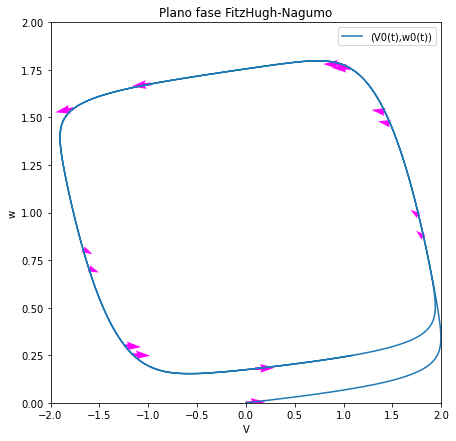

In [6]:
%matplotlib inline

### Parámetros

beta = 1.0
I1 = 1.0
a = 0.7
b = 0.8
tau = 12.5

### Campo vectorial

def FHN(x,y):
    dx = beta*x-x**3/3-y+I1
    dy = 1/tau*(x-b*y+a)
    return [dx,dy]

def FHN_int(u,t):
    V, w = u
    dV = FHN(V,w)[0]
    dw = FHN(V,w)[1]
    return [dV,dw]

v0 = 0.0
w0 = 0.0
u0 = [v0,w0]

T = linspace(0,75,7501)

I = linspace(0,len(T),15)

U0 = odeint(FHN_int,u0,T)
V0 = U0[:,0]
W0 = U0[:,1]

fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Plano fase FitzHugh-Nagumo')
ax.plot(V0,W0,label='(V0(t),w0(t))')
for k in range(len(I)-1):
    i = int(I[k])
    Vt = V0[i]
    Wt = W0[i]
    ut, vt = FHN(Vt,Wt)
    if norm([ut,vt])>0.01:
        ut = ut/norm([ut,vt])
        vt = vt/norm([ut,vt])
        p = plt.quiver([Vt],[Wt],[ut],[vt],color='magenta',scale_units='x',scale=5.0)

ax.legend()
ax.set_xlabel('V')
ax.set_ylabel('w')
ax.set_ylim(0.0,2.0)
ax.set_xlim(-2.0,2.0)

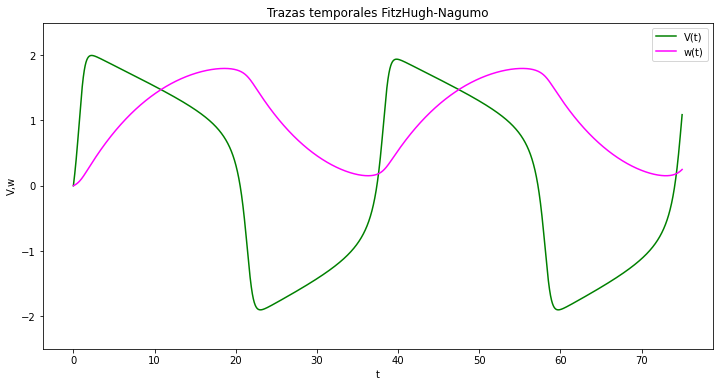

In [7]:
pt = plt.figure(figsize=(12,6))
pt = plt.plot(T,V0,label='V(t)', color = 'green')
pt = plt.plot(T,W0,label='w(t)', color = 'magenta')
pt = plt.title('Trazas temporales FitzHugh-Nagumo')
pt = plt.xlabel('t')
pt = plt.ylabel('V,w')
pt = plt.ylim(-2.5,2.5)
pt = plt.legend()

## Modelo de actividad retinal

Un modelo de retroalimentación positiva describe la respuesta de dos neuronas idénticas en el lóbulo frontal que tiene un simio frente a una discriminación entre dos señales luminosas (memoria a corto plazo). Estas neuronas se excitan mutuamente mediante el sistema

\begin{align*}
\dfrac{\mathrm{d}E_1}{\mathrm{d}t}&=\dfrac{1}{\tau}\left(-E_1+\dfrac{100(3E_2)^2}{120^2+(3E_2)^2}\right),\\
\dfrac{\mathrm{d}E_2}{\mathrm{d}t}&=\dfrac{1}{\tau}\left(-E_2+\dfrac{100(3E_1)^2}{120^2+(3E_1)^2}\right).
\end{align*}

A la función de interacción $f(e)=\tfrac{100(3e)^2}{120^2+(3e)^2}$ le llamamos del tipo **Naka-Rushton**, y dibuja una *s* creciente acotada entre 0 y 100 para $e\geqslant0$. En el sistema anterior las variables $E_1$ y $E_2$ denotan la *tasa de actividad* de las neuronas 1 y 2, respectivamente, por lo que valores altos de cada variable indica un número alto de potenciales de acción por unidad de tiempo. Más adelante veremos varios detalles interesantes de este tipo de modelos, pero por ahora los trataremos como un ejemplo más de retroalimentación.

Directamente calculamos las derivadas para obtener

$$\dfrac{\partial\dot{E}_1}{\partial E_2}\dfrac{\partial\dot{E}_2}{\partial E_1}=\dfrac{1800^2}{\tau^2}\dfrac{120^2 E_2}{(120^2+(3E_2)^2)^2}\dfrac{120^2 E_1}{(120^2+(3E_1)^2)^2},$$

que es positivo siempre que $E_1$ y $E_2$ sean positivos. A diferencia de los ejemplos anteriores, ests sistema presenta convergencia a puntos de equilibrio como se ve a continuación.

(0.0, 100.0)

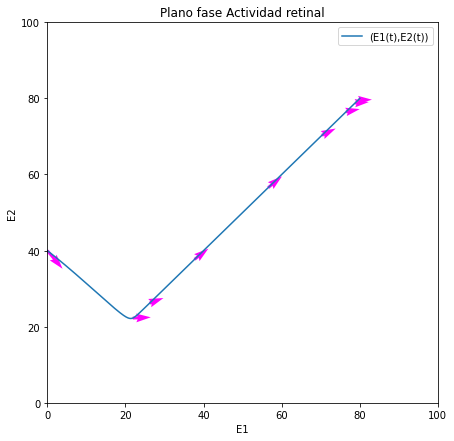

In [10]:
tau = 20.0

def E1dyn(E1,E2):
    return 1/tau*(-E1+100*(3*E2)**2/(120**2+(3*E2)**2))

def E2dyn(E1,E2):
    return 1/tau*(-E2+100*(3*E1)**2/(120**2+(3*E1)**2))

def dNR(E1,E2):
    dE1 = E1dyn(E1,E2)
    dE2 = E2dyn(E1,E2)
    return [dE1,dE2]

def dNR_int(u,t):
    E1, E2 = u
    return dNR(E1,E2)

e10 = 0.0
e20 = 40.0
u0 = [e10,e20]

T = linspace(0,500,50001)
I = linspace(0,len(T),15)

U0 = odeint(dNR_int,u0,T)
E10 = U0[:,0]
E20 = U0[:,1]

fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Plano fase Actividad retinal')
ax.plot(E10,E20,label='(E1(t),E2(t))')
for k in range(len(I)-1):
    i = int(I[k])
    Vt = E10[i]
    Wt = E20[i]
    ut, vt = dNR(Vt,Wt)
    if norm([ut,vt])>0.01:
        ut = ut/norm([ut,vt])
        vt = vt/norm([ut,vt])
        p = plt.quiver([Vt],[Wt],[ut],[vt],color='magenta',scale_units='x',scale=0.2)

ax.legend()
ax.set_xlabel('E1')
ax.set_ylabel('E2')
ax.set_ylim(0.0,100.0)
ax.set_xlim(0.0,100.0)

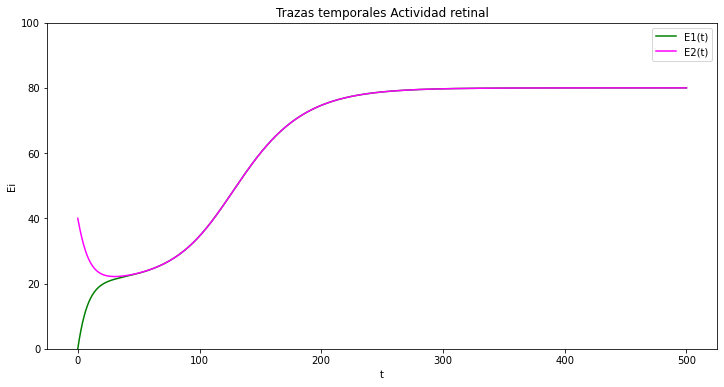

In [11]:
pt = plt.figure(figsize=(12,6))
pt = plt.plot(T,E10,label='E1(t)', color = 'green')
pt = plt.plot(T,E20,label='E2(t)', color = 'magenta')
pt = plt.title('Trazas temporales Actividad retinal')
pt = plt.xlabel('t')
pt = plt.ylabel('Ei')
pt = plt.ylim(0,100)
pt = plt.legend()

## Modelo de Hodgkin-Huxley

Cuando el número de variables aumenta, la forma de medir retroalimentación también se incrementa. En el caso del modelo 4-dimensional

\begin{align*}
C\tfrac{\mathrm{d}V}{\mathrm{d}t}&=I-\bar{g}_{Na}m^3h(V-E_{Na})-\bar{g}_Kn^4(V-E_K)-g_L(V-E_L),\\
\tfrac{\mathrm{d}m}{\mathrm{d}t}&=\alpha_m(V)(1-m)-\beta_m(V)m=\dfrac{m_{\infty}(V)-m}{\tau_m(V)},\\
\tfrac{\mathrm{d}h}{\mathrm{d}t}&=\alpha_h(V)(1-h)-\beta_h(V)h=\dfrac{h_{\infty}(V)-h}{\tau_h(V)},\\
\tfrac{\mathrm{d}n}{\mathrm{d}t}&=\alpha_n(V)(1-n)-\beta_n(V)n=\dfrac{n_{\infty}(V)-n}{\tau_n(V)},
\end{align*}

podemos hablar de retroalimentación entre el potencial de membrana $V$ y cada una de las compuertas $m$, $h$, $n$. En este caso es difícil seguir el procedimiento de derivadas por el alto número de funciones auxiliares que presenta el modelo anterior. Sin embargo, podemos hacer algunas observaciones generales:

- $m$ y $n$ son variables de activación, así que se incrementan conforme $V$ incrementa. Entonces
$$\dfrac{\partial\dot{m}}{\partial V}>0, \ \ \ \ \dfrac{\partial\dot{n}}{\partial V}>0.$$
- $h$ es una variable de inactivación, por lo que decrece frente a incrementos de $V$. Tenemos
$$\dfrac{\partial\dot{h}}{\partial V}<0.$$
- $I_{\mathrm{Na}}=\bar{g}_{Na}m^3h(V-E_{\mathrm{Na}})$ es una corriente entrante, así que $V$ es, en promedio, menor a $E_{\mathrm{Na}}$.
- $I_{\mathrm{K}}=\bar{g}_{K}n^4(V-E_{\mathrm{K}})$ es una corriente saliente, así que $V$ es, en promedio, mayor a $E_{\mathrm{K}}$.

Así podemos calcular la retroalimentación que recibe $V$ a través de cada una de las compuertas, de manera que
$$\begin{align*}
\dfrac{\partial\dot{m}}{\partial V}\dfrac{\partial\dot{V}}{\partial m}&=-3\bar{g}_{Na}m^2h(V-E_{\mathrm{Na}})\dfrac{\partial\dot{m}}{\partial V}>0,\\
\dfrac{\partial\dot{h}}{\partial V}\dfrac{\partial\dot{V}}{\partial m}&=-\bar{g}_{Na}m^3(V-E_{\mathrm{Na}})\dfrac{\partial\dot{h}}{\partial V}<0,\\
\dfrac{\partial\dot{n}}{\partial V}\dfrac{\partial\dot{V}}{\partial m}&=-4\bar{g}_{K}n^3(V-E_{\mathrm{K}})\dfrac{\partial\dot{n}}{\partial V}<0.
\end{align*}$$

En el caso de modelos tan complejos como el anterior, podemos clasificar la *velocidad* de cada retroalimentación comparando las constantes de tiempo de las distintas compuertas. Para esto integraremos el sistema y luego evaluaremos (y graficaremos) las constantes $\tau_m(V)$, $\tau_h(V)$, y $\tau_n(V)$.

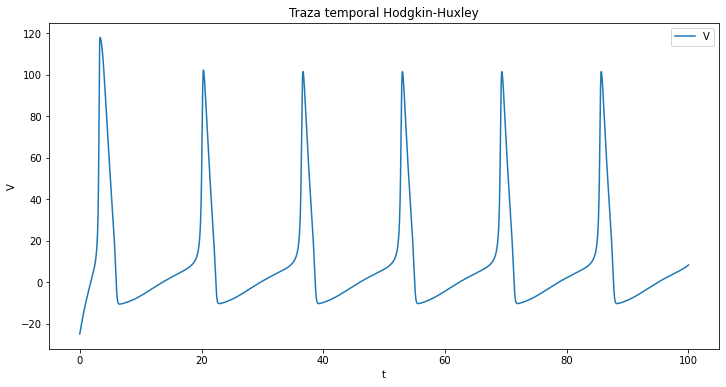

In [12]:
%matplotlib inline

C = 1.0
I = 7.0

EK = -12.0
ENa = 120.0
EL = 10.6

gK = 36.0
gNa = 120.0
gL = 0.3

def am(V):
    return 0.1*(25-V)/(exp((25-V)/10)-1)

def ah(V):
    return 0.07*exp(-V/20)

def an(V):
    return 0.01*(10-V)/(exp((10-V)/10)-1)

def bm(V):
    return 4.0*exp(-V/18)

def bh(V):
    return 1/(exp((30-V)/10)+1)

def bn(V):
    return 0.125*exp(-V/80)

def minf(V):
    return am(V)/(am(V)+bm(V))

def hinf(V):
    return ah(V)/(ah(V)+bh(V))

def ninf(V):
    return an(V)/(an(V)+bn(V))

def taum(V):
    return 1/(am(V)+bm(V))

def tauh(V):
    return 1/(ah(V)+bh(V))

def taun(V):
    return 1/(an(V)+bn(V))

def Vdyn(V,m,h,n):
    return (I-gNa*m**3*h*(V-ENa)-gK*n**4*(V-EK)-gL*(V-EL))/C

def mdyn(V,m):
    return am(V)*(1-m)-bm(V)*m

def hdyn(V,h):
    return ah(V)*(1-h)-bh(V)*h

def ndyn(V,n):
    return an(V)*(1-n)-bn(V)*n

def HH(u,t):
    V, m, h, n = u
    dV = Vdyn(V,m,h,n)
    dm = mdyn(V,m)
    dh = hdyn(V,h)
    dn = ndyn(V,n)
    return [dV,dm,dh,dn]

V0 = -25.0
m0 = minf(V0)
h0 = hinf(V0)
n0 = ninf(V0)
u0 = [V0,m0,h0,n0]

t = linspace(0,100,10001)

U = odeint(HH,u0,t)
V = U[:,0]
m = U[:,1]
h = U[:,2]
n = U[:,3]

p = plt.figure(figsize = (12,6))
p = plt.plot(t,V,label='V')
p = plt.title('Traza temporal Hodgkin-Huxley')
p = plt.xlabel('t')
p = plt.ylabel('V')
p = plt.legend()

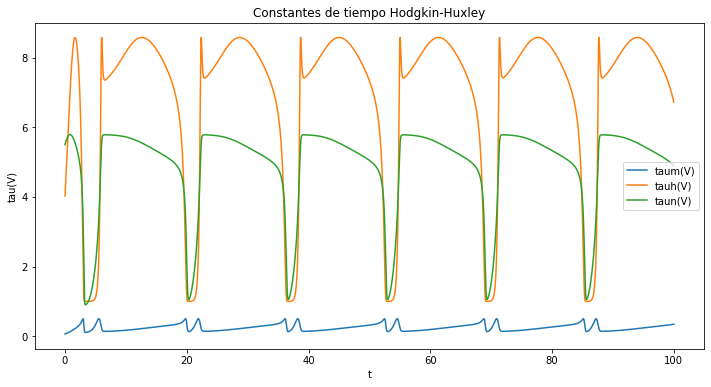

In [25]:
p = plt.figure(figsize = (12,6))
p = plt.plot(t,taum(V),label='taum(V)')
p = plt.plot(t,tauh(V),label='tauh(V)')
p = plt.plot(t,taun(V),label='taun(V)')
p = plt.title('Constantes de tiempo Hodgkin-Huxley')
p = plt.xlabel('t')
p = plt.ylabel('tau(V)')
p = plt.legend()

Dado que las constantes de tiempo aparecen dividiendo a las compuertas, valores mayores de $\tau_j(V)$ indican que la variable es más lenta. Aunque no podemos establecer comparaciones generales, es posible decir que en promedio la variable más rápida es $m$, mientras que $h$ es la compuerta más lenta. En resumen, tenemos

- Retroalimentación positiva rápida sobre $V$ mediante la compuerta de activación de sodio $m$,
- Retroalimentación negativa lenta sobre $V$ mediante la compuerta de inactivación de sodio $h$,
- Retroalimentación negativa lenta sobre $V$ mediante la compuerta de activación de potasio $n$.

El efecto concreto de cada retroalimentación sobre el potencial de membrana es estudiado mediante la teoría de **Conductancia dinámicas de entrada** (Drion 2015).